# Overview

# Business Understanding

### problem and stakeholder

what is the business problem?

# Data Understanding (a lil EDA)

In [141]:
# imports
import pandas as pd
import seaborn as sns
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re
from collections import defaultdict
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

In [2]:
# upload the data
data = pd.read_csv('./tweet_data.csv', encoding="latin1")
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
data.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


I can see there are 4 different values for my target column all the way on the right. I wonder what those values are and their distribution.

In [6]:
data.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

# Data Preparation

In [7]:
# data[data['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"]

to do:

* turn target into numbers with LE()
* change "i can't tell" into "no emotion"

In [8]:
data = data[data.is_there_an_emotion_directed_at_a_brand_or_product != "I can't tell"]

In [9]:
data.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [10]:
le = LabelEncoder()

target = pd.Series(le.fit_transform(data.is_there_an_emotion_directed_at_a_brand_or_product))
target.value_counts()

1    5389
2    2978
0     570
dtype: int64

0 = negative
1 = no emotion
2 = positive

In [11]:
data['tweet_text'].astype(str)

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: tweet_text, Length: 8937, dtype: object

In [12]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data.tweet_text,
                                                    target,
                                                    random_state=42)

In [13]:
sw = stopwords.words('english')
regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")

In [14]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [15]:
def preprocess_text(text_list, tokenizer, stopwords_list):
    
    '''
    Takes in a list of strings, a tokenizer, and list of stopwords and
    returns a list lowercased, tokenized, removes stopwords,
    and lemmatizes the words. 
    '''
    
    # lowercase
    lower = [str(text).lower() for text in text_list]
    
    # tokenize
    tokenized = [tokenizer.tokenize(tweet) for tweet in lower]
    
    # stopwords
    no_stops = []
    for item in tokenized:
        temp = []
        for token in item:
            if token not in stopwords_list:
                temp.append(token)
        no_stops.append(temp)  
    
    # preparation for lemmatization
    tags = [pos_tag(tokens) for tokens in no_stops]
    
    better_tags = []
    for item in tags:
        temp1 = []
        for word in item:
            temp1.append((word[0], get_wordnet_pos(word[1])))
        better_tags.append(temp1)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    lem = []
    for item in better_tags:
        temp2 = []
        for word in item:
            temp2.append(lemmatizer.lemmatize(word[0], word[1]))
        lem.append(temp2)
        
    preprocessed = [' '.join(i) for i in lem]
    
    return preprocessed

In [16]:
testing123 = ['This is a test.', "It's a list of sentences that I made up.", "I like to think that I'm cool!!!"]

In [17]:
lower = [str(text).lower() for text in testing123]
lower

['this is a test.',
 "it's a list of sentences that i made up.",
 "i like to think that i'm cool!!!"]

In [18]:
type(lower)

list

In [19]:
regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
tokenized = [regex_token.tokenize(tweet) for tweet in lower]
tokenized

[['this', 'is', 'a', 'test'],
 ['it', 's', 'a', 'list', 'of', 'sentences', 'that', 'i', 'made', 'up'],
 ['i', 'like', 'to', 'think', 'that', 'i', 'm', 'cool']]

In [20]:
no_stops = []
for item in tokenized:
    temp = []
    for token in item:
        if token not in sw:
            temp.append(token)
    no_stops.append(temp)   

no_stops

[['test'], ['list', 'sentences', 'made'], ['like', 'think', 'cool']]

In [21]:
tags = [pos_tag(tokens) for tokens in no_stops]
tags

[[('test', 'NN')],
 [('list', 'NN'), ('sentences', 'NNS'), ('made', 'VBD')],
 [('like', 'IN'), ('think', 'VBP'), ('cool', 'JJ')]]

In [22]:
better_tags = []
for item in tags:
    temp1 = []
    for word in item:
        temp1.append((word[0], get_wordnet_pos(word[1])))
    better_tags.append(temp1)

better_tags
    
        
# doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]


# better_tags = [(i[0], get_wordnet_pos(i[1])) for i in tags]
# better_tags

[[('test', 'n')],
 [('list', 'n'), ('sentences', 'n'), ('made', 'v')],
 [('like', 'n'), ('think', 'v'), ('cool', 'a')]]

In [23]:
lemmatizer = WordNetLemmatizer()

lem = []
for item in better_tags:
    temp2 = []
    for word in item:
        temp2.append(lemmatizer.lemmatize(word[0], word[1]))
    lem.append(temp2)

lem

[['test'], ['list', 'sentence', 'make'], ['like', 'think', 'cool']]

In [24]:
processed = [' '.join(i) for i in lem]
processed

['test', 'list sentence make', 'like think cool']

In [25]:
preprocess_text(testing123, regex_token, sw)

['test', 'list sentence make', 'like think cool']

In [26]:
X_train = preprocess_text(X_train, regex_token, sw)
X_train

['mention android app know battery killer sxsw',
 'interest rt mention apple open pop shop sxsw link sxsw sxswi popupshop apple',
 'look like fun session sxsw quot mistake make build nextflix iphone quot link',
 'fun w mention new check feature iphone see mention late article quot roll square quot link sxsw',
 'cloud vc post nothing sxsw x startup founder amp ceo go dark side link tcn',
 'rt mention marissa mayer google connect digital amp physical world mobile link sxsw',
 'next sxsw head design ipad apps baby boomer wish apps yet tg',
 'tech meet guy buy first ipad sxsw apple pop store link',
 'rt mention rt mention best thing heard weekend sxsw quot give ipad money japan relief need ipad quot mention',
 'rt mention design baby boomer john mcree ipad design sxsw yourmom',
 'rt mention text quot sxsw quot chance win ipad draw friend sxsw must present win see ya link',
 'future google map sxsw kia recall optimas top advertising news link',
 'finally get new iphone tweet phone time sxsw

In [27]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

# Models / Evaluation

## Vectorized

In [28]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=42)

In [94]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [95]:
len(cv.vocabulary_)

5927

## Dummy Model

In [30]:
dummy = DummyClassifier().fit(X_t_vec, y_t)

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

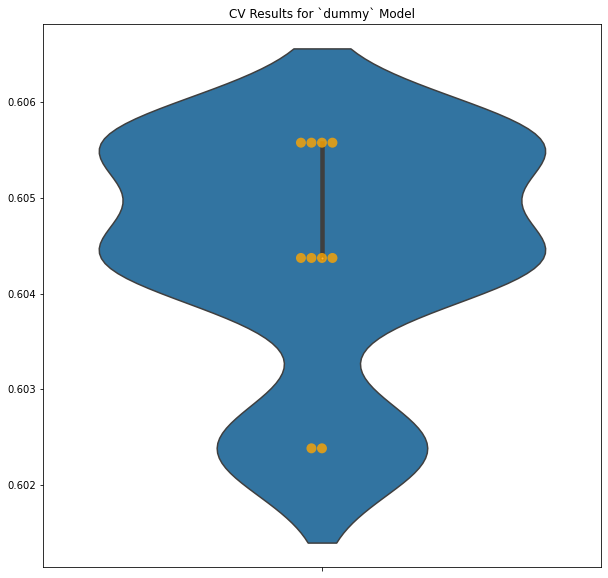

In [31]:
dummy_model = ModelWithCV(
    dummy,
    model_name = 'dummy',
    X=X_t_vec,
    y=y_t)
fig, ax = plt.subplots(figsize=(10,10))

dummy_model.plot_cv(ax=ax)

In [32]:
dummy_model.print_cv_summary()

CV Results for `dummy` model:
            0.60446 ± 0.00117 accuracy
        


In [33]:
dummy.score(X_val_vec, y_val)

0.5936754176610979

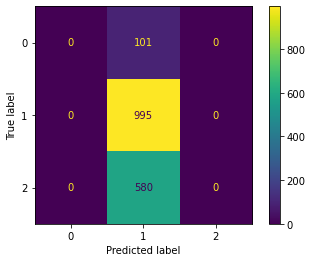

In [34]:
y_preds = dummy.predict(X_val_vec)
cm = confusion_matrix(y_val, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [35]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.59      1.00      0.75       995
           2       0.00      0.00      0.00       580

    accuracy                           0.59      1676
   macro avg       0.20      0.33      0.25      1676
weighted avg       0.35      0.59      0.44      1676



/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Multinomial Naive Bayes

In [36]:
nb = MultinomialNB().fit(X_t_vec, y_t)

<AxesSubplot:title={'center':'CV Results for `nb` Model'}>

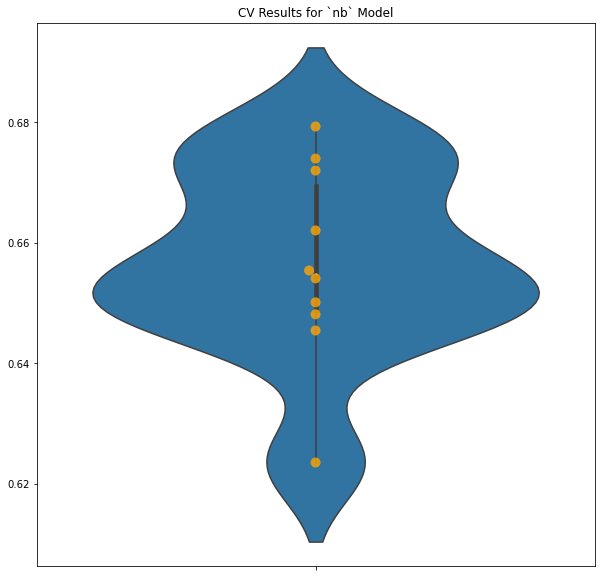

In [37]:
nb_model = ModelWithCV(
    nb,
    model_name = 'nb',
    X=X_t_vec,
    y=y_t)
fig, ax = plt.subplots(figsize=(10,10))

nb_model.plot_cv(ax=ax)

In [38]:
nb_model.print_cv_summary()

CV Results for `nb` model:
            0.65638 ± 0.01557 accuracy
        


In [39]:
nb.score(X_val_vec, y_val)

0.6545346062052506

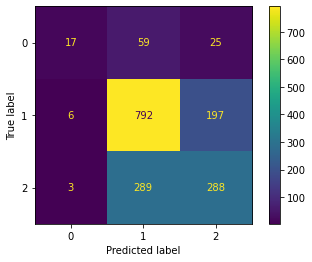

In [40]:
y_preds = nb.predict(X_val_vec)
cm = confusion_matrix(y_val, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [41]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.65      0.17      0.27       101
           1       0.69      0.80      0.74       995
           2       0.56      0.50      0.53       580

    accuracy                           0.65      1676
   macro avg       0.64      0.49      0.51      1676
weighted avg       0.65      0.65      0.64      1676



now with limited features

### Top 10 Words

In [151]:
cv = CountVectorizer(max_features=10)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [152]:
# how many words is the model looking at?
len(cv.vocabulary_)

10

In [153]:
X_t_vec

,apple,google,ipad,iphone,link,mention,quot,rt,store,sxsw
4241,0,0,0,1,0,1,0,1,0,1
1930,0,1,0,0,0,0,0,0,0,1
3171,0,0,0,1,0,0,0,0,0,1
8572,0,0,1,0,0,0,0,0,0,1
5598,0,0,0,1,0,2,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
8380,0,0,0,0,0,1,0,0,0,2
145,1,0,1,0,0,2,0,0,0,1
1804,0,1,0,0,0,0,0,0,0,1
2866,1,0,0,0,1,1,0,1,0,1


I don't think these top 10 words are going to be very helpful. I might consider adding some of them to the stopwords list.

In [120]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [121]:
nb.score(X_val_vec, y_val)

0.5978520286396182

### Top 100 Words

In [164]:
cv = CountVectorizer(max_features=100)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [165]:
# how many words is the model looking at?
len(cv.vocabulary_)

100

In [166]:
X_t_vec

,amp,android,app,apple,apps,around,austin,awesome,best,big,...,tweet,update,use,user,via,want,win,work,would,year
4241,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5598,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8380,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2866,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [117]:
nb.score(X_val_vec, y_val)

0.5948687350835322

### Top 200 Words

In [122]:
cv = CountVectorizer(max_features=200)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [123]:
# how many words is the model looking at?
len(cv.vocabulary_)

200

In [124]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [125]:
nb.score(X_val_vec, y_val)

0.6026252983293556

### Minimum Document Frequency of 5%

In [173]:
cv = CountVectorizer(min_df=.05, max_df=0.5)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [174]:
# how many words is the model looking at?
len(cv.vocabulary_)

21

In [175]:
X_t_vec

,amp,android,app,apple,austin,circle,get,google,ipad,iphone,...,link,network,new,open,pop,quot,rt,social,store,today
4241,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1930,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3171,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8572,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5598,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8380,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1804,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2866,0,0,0,1,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [128]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [129]:
nb.score(X_val_vec, y_val)

0.5865155131264916

### Minimum Document Frequency of 2%

In [130]:
cv = CountVectorizer(min_df=0.02)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [131]:
# how many words is the model looking at?
len(cv.vocabulary_)

61

In [132]:
nb = MultinomialNB().fit(X_t_vec, y_t)

In [133]:
nb.score(X_val_vec, y_val)

0.5894988066825776

## Random Forest Model

In [156]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [135]:
rf = RandomForestClassifier().fit(X_t_vec, y_t)

<AxesSubplot:title={'center':'CV Results for `rf` Model'}>

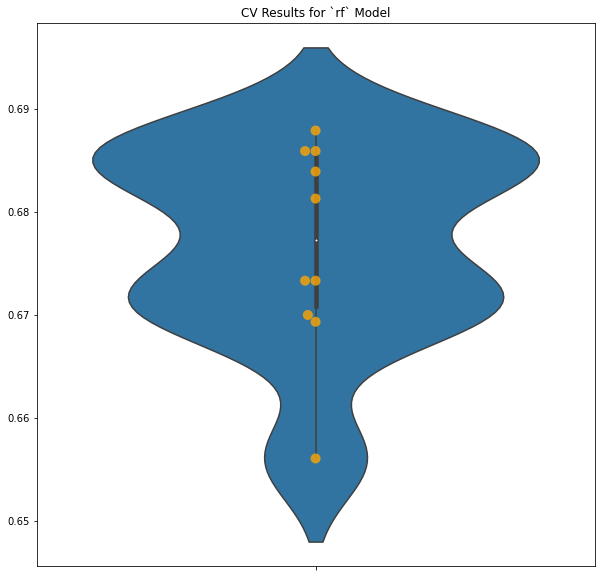

In [136]:
rf_model = ModelWithCV(
    rf,
    model_name = 'rf',
    X=X_t_vec,
    y=y_t)
fig, ax = plt.subplots(figsize=(10,10))

rf_model.plot_cv(ax=ax)

In [137]:
rf_model.print_cv_summary()

CV Results for `rf` model:
            0.67668 ± 0.00956 accuracy
        


In [138]:
rf.score(X_val_vec, y_val)

0.6694510739856802

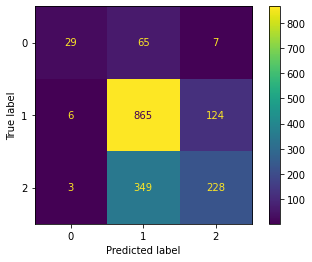

In [139]:
y_preds = rf.predict(X_val_vec)
cm = confusion_matrix(y_val, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [140]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.76      0.29      0.42       101
           1       0.68      0.87      0.76       995
           2       0.64      0.39      0.49       580

    accuracy                           0.67      1676
   macro avg       0.69      0.52      0.55      1676
weighted avg       0.67      0.67      0.64      1676



### Random Forest with gridsearch

In [143]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10]
}

gs_rf = GridSearchCV(rf, param_grid, cv=3)
gs_rf.fit(X_t_vec, y_t)

gs_rf.best_params_

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

<AxesSubplot:title={'center':'CV Results for `gs_rf_model` Model'}>

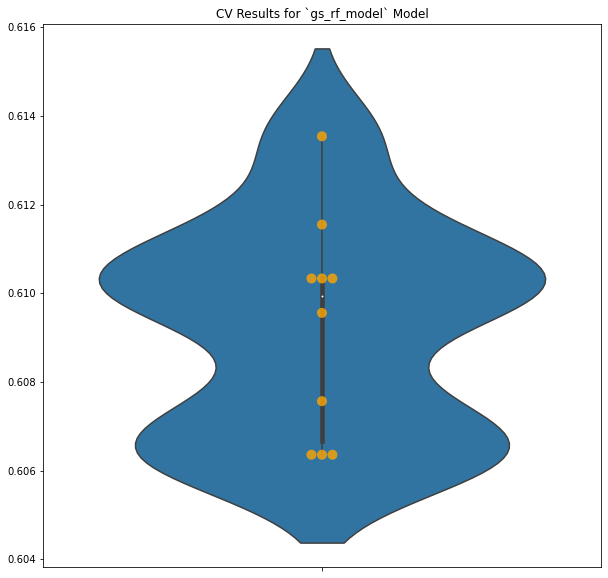

In [146]:
gs_rf_model = ModelWithCV(
    gs_rf.best_estimator_,
    model_name = 'gs_rf_model',
    X=X_t_vec,
    y=y_t)
fig, ax = plt.subplots(figsize=(10,10))

gs_rf_model.plot_cv(ax=ax)

In [148]:
rf_model.print_cv_summary()

CV Results for `rf` model:
            0.67668 ± 0.00956 accuracy
        


In [145]:
gs_rf.best_score_

0.6088337548534178

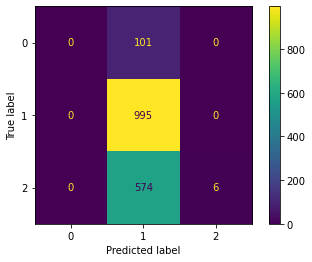

In [149]:
best_gs = gs_rf.best_estimator_
y_preds = best_gs.predict(X_val_vec)
cm = confusion_matrix(y_val, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [150]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.60      1.00      0.75       995
           2       1.00      0.01      0.02       580

    accuracy                           0.60      1676
   macro avg       0.53      0.34      0.26      1676
weighted avg       0.70      0.60      0.45      1676



/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

maybe the data needs to be more balanced?

In [157]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [158]:
from imblearn.over_sampling import SMOTE

In [163]:
# Previous original class distribution
print('Original class distribution: \n')
print(y_t.value_counts())
smote = SMOTE()
# X_train.reshape(-1,1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_t_resampled).value_counts()) 

Original class distribution: 

1    3038
2    1673
0     315
dtype: int64


ValueError: Expected 2D array, got 1D array instead:
array=['mention android app know battery killer sxsw'
 'interest rt mention apple open pop shop sxsw link sxsw sxswi popupshop apple'
 'look like fun session sxsw quot mistake make build nextflix iphone quot link'
 ...
 'rt mention arduino android flame skull link refrigerator speaks salon k pm mention mention sxsw smartthings'
 'make soundcloud ambassador sxsw upload music show amp reward rt mention soundcloud android app fresh'
 'tech apple open pop store austin sxsw link technology'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Conclusion